### ML3 HW3
#### LT5
Borromeo, Chloe<br>
Castanares, Michael Lawrence<br>
Garcia, Fernando Jude<br>
Tan, Allan

Assignment Instructions<br>
Done by LT<br>
Total: 12 points<br>
Submit: Python Notebook (.ipynb)<br>
Task (4pts each method)<br>
Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region<br>

Using the PJM West Region: 2001-2018 (PJMW) estimated hourly energy consumption data from PJM in Megawatts: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data. Forecast the total daily consumption one month in advance. Compare the MAE and MAPE accuracy of the best:<br><br>
ARIMA<br>
LSTM<br>
GRU<br>

### Load the data

In [1]:
import pandas as pd

In [2]:
file = 'data/PJMW_hourly.csv'

In [3]:
df = pd.read_csv(file)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Resample to get daily consumption

In [5]:

df.index = pd.to_datetime(df['Datetime'])
df_daily = df.resample('D').sum('PJMW_MW')

# print(df_daily)

# Stabilize seasonality
# standardize to 30 days
# Comment the succeeding parts out if not needed and simply use df_daily[:-1]

# day_31_list = []
# for item in df_daily.index:
#     if (item.day == 31):
#         day_31_list.append(item)
# df_daily_30 = df_daily.loc[~df_daily.index.isin(day_31_list)]

# # print(df_daily_30)


# # Remove February because it only has 28/29 days?
# feb_list = []
# for item in df_daily_30.index:
#     if (item.month == 2):
#         feb_list.append(item)

# df_daily_30 = df_daily_30.loc[~df_daily_30.index.isin(feb_list)]
# # # Remove Aug 3 2018 because it does not have a complete day's worth of data?
# print(df_daily_30)

# df_daily_30 = df_daily_30[:-1]

# print(df_daily_30)

df_daily = df_daily[:-1]

### 1. ARIMA

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


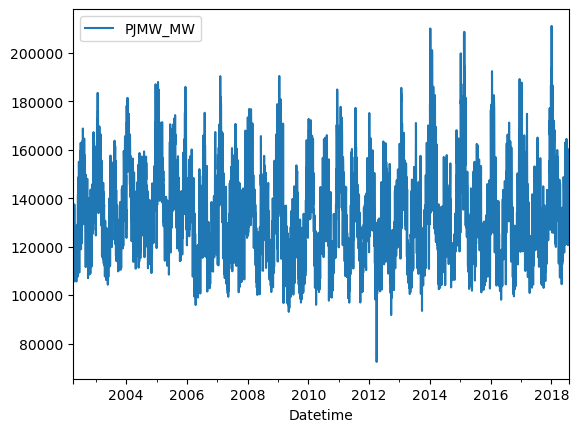

In [7]:
from matplotlib import pyplot
%matplotlib inline
df_daily.plot()
pyplot.show()

The data needs to be stationary for ARIMA to work. Let's check that.

In [8]:
# ! conda install statsmodels -y

In [9]:
from statsmodels.tsa.stattools import adfuller

series = df_daily['PJMW_MW']
# Perform the ADF test to check stationarity
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.264578
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The results show that the test statistic value -7.264578 is smaller than the critical value at 1% of -3.431. This suggests the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

In [10]:
# ! conda install scikit-learn -y

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm 
import timeit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    days_in_a_month = 30  # Define the number of days in a month
    train_size = int(len(X) - days_in_a_month)  # Use 1 month validation
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)


    # Make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        # Difference data
        diff = difference(history, days_in_a_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, days_in_a_month)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (MAE)
    mae = mean_absolute_error(test, predictions)
    return mae


In [12]:
X = series.values
start = timeit.default_timer()
mar = evaluate_arima_model(X, (0, 0, 1))
exec_time = timeit.default_timer() - start
print(f'MAE={mar} Execution Time: {exec_time}')


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

MAE=10424.651074758154 Execution Time: 10.408188041001267


Do GridSearch to find the optimal values of p,d and q

In [13]:
from itertools import product

# Define ranges for p, d, q
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

# Initialize a dictionary to store the results
results = {}
start = timeit.default_timer()
# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    try:
        mae = evaluate_arima_model(X, order)
        # Store the result in the dictionary
        results[order] = mae
        print(f"Order {order}, MAE: {mae}")
    except:
        print(f"Error trying to converge Order {order}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_mae = results[best_order]
exec_time = timeit.default_timer() - start
# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest MAE: {best_mae}, Execution Time: {exec_time}")

100%|██████████| 30/30 [00:01<00:00, 19.00it/s]


Order (0, 0, 0), MAE: 17598.907950293655


100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Order (0, 0, 1), MAE: 10424.651074758154


100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Order (0, 0, 2), MAE: 9625.625666426491


100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Order (0, 0, 3), MAE: 9585.596542394518


100%|██████████| 30/30 [00:01<00:00, 19.68it/s]


Order (0, 1, 0), MAE: 11817.8


100%|██████████| 30/30 [00:05<00:00,  5.42it/s]


Order (0, 1, 1), MAE: 11608.360367453692


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Order (0, 1, 2), MAE: 9597.946796061584


100%|██████████| 30/30 [00:15<00:00,  1.98it/s]


Order (0, 1, 3), MAE: 9352.005443109474


100%|██████████| 30/30 [00:04<00:00,  6.87it/s]


Order (1, 0, 0), MAE: 10334.838408658428


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Order (1, 0, 1), MAE: 9070.25081039144


100%|██████████| 30/30 [00:18<00:00,  1.58it/s]


Order (1, 0, 2), MAE: 9041.10165759928


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


Order (1, 0, 3), MAE: 9001.971894532679


100%|██████████| 30/30 [00:02<00:00, 14.50it/s]


Order (1, 1, 0), MAE: 12145.156791099736


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


Order (1, 1, 1), MAE: 11170.664560527652


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Order (1, 1, 2), MAE: 9264.244361903611


100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


Order (1, 1, 3), MAE: 9318.376782968764


100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


Order (2, 0, 0), MAE: 10295.519031642405


100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


Order (2, 0, 1), MAE: 9076.007531362058


100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


Order (2, 0, 2), MAE: 9087.719358118184


100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Order (2, 0, 3), MAE: 8968.57537614159


100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


Order (2, 1, 0), MAE: 9704.226674988504


100%|██████████| 30/30 [00:14<00:00,  2.00it/s]


Order (2, 1, 1), MAE: 9240.386254597712


100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


Order (2, 1, 2), MAE: 9374.278835712435


100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


Order (2, 1, 3), MAE: 9372.395102782659


100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Order (3, 0, 0), MAE: 9351.821697809264


100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Order (3, 0, 1), MAE: 8827.395121324262


100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


Order (3, 0, 2), MAE: 9606.868144151058


  0%|          | 0/30 [00:00<?, ?it/s]/home/andy/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 1/30 [00:04<02:11,  4.55s/it]/home/andy/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 2/30 [00:09<02:09,  4.63s/it]/home/andy/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 3/30 [00:13<02:05,  4.64s/it]/home/andy/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/base/model.py:607: Converg

Order (3, 0, 3), MAE: 9538.572088470504


100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


Order (3, 1, 0), MAE: 9559.719453919468


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


Order (3, 1, 1), MAE: 9303.089266303019


100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


Order (3, 1, 2), MAE: 9311.80738886815


100%|██████████| 30/30 [00:54<00:00,  1.82s/it]

Order (3, 1, 3), MAE: 9860.792373856848

Best Order: (3, 0, 1), Lowest MAE: 8827.395121324262, Execution Time: 739.1410486809982


### 2. LSTM

### 3. GRU